In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 7.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data_corrected_with_ids = pd.read_pickle("/content/drive/MyDrive/Other/corrected_data1.pkl")

In [ ]:
data_corrected_with_ids["target"] = data_corrected_with_ids["conversions"].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
cols_to_use = list(data_corrected_with_ids.columns)

cols_to_use.remove("date_time")
cols_to_use.remove("conversions")
cols_to_use.remove("impressions")

In [ ]:
train_df = data_corrected_with_ids.loc[data_corrected_with_ids["date_time"] < "2016-09-14", cols_to_use]
valid_df = data_corrected_with_ids.loc[data_corrected_with_ids["date_time"] > "2016-09-14", cols_to_use]

In [ ]:
categorical_cols = ["banner_id", "advertiser_id", "offer_id", "zone_id", "affiliate_id", "geo", "region_code", "city_code",
                    "os_type", "os", "os_version", "device_type", "device", "browser", "lang", "isp", "mobile_isp",
                    "proxy", "netspeed", "day_of_week", "hour"]
nums_cols = ["varp", "varcc", "varpp"]

In [ ]:
transformed_train_list = []
transformed_valid_list = []
for colname in categorical_cols:
    ohe_enc = OneHotEncoder(dtype=np.int8, handle_unknown='ignore', min_frequency=5, sparse_output=True)
    ohe_enc.fit(train_df[[colname]])
    cat_ohe_train = ohe_enc.transform(train_df[[colname]])
    cat_ohe_valid = ohe_enc.transform(valid_df[[colname]])
    for n in range(1, 11):
        pca = TruncatedSVD(n_components=n).fit(cat_ohe_train)
        explained = pca.explained_variance_ratio_
        if sum(explained) > 0.9:
            break
    print(f"Feature '{colname}', components: {n}")
    X_train_pca = pca.transform(cat_ohe_train)
    X_valid_pca = pca.transform(cat_ohe_valid)
    pca_train_df = pd.DataFrame(X_train_pca, columns=[f"PCA_{i+1}_{colname}" for i in range(n)])
    pca_valid_df = pd.DataFrame(X_valid_pca, columns=[f"PCA_{i+1}_{colname}" for i in range(n)])
    transformed_train_list.append(pca_train_df)
    transformed_valid_list.append(pca_valid_df)

Feature 'banner_id', components: 10
Feature 'advertiser_id', components: 10
Feature 'offer_id', components: 10
Feature 'zone_id', components: 10
Feature 'affiliate_id', components: 10
Feature 'geo', components: 10
Feature 'region_code', components: 10
Feature 'city_code', components: 10
Feature 'os_type', components: 2
Feature 'os', components: 4
Feature 'os_version', components: 9
Feature 'device_type', components: 3
Feature 'device', components: 3
Feature 'browser', components: 7
Feature 'lang', components: 9
Feature 'isp', components: 10
Feature 'mobile_isp', components: 10
Feature 'proxy', components: 2
Feature 'netspeed', components: 4
Feature 'day_of_week', components: 6
Feature 'hour', components: 10


In [ ]:
train_df_linear = pd.concat([train_df.drop(categorical_cols, axis=1).reset_index(drop=True)] + transformed_train_list,
                            axis=1)
valid_df_linear = pd.concat([valid_df.drop(categorical_cols, axis=1).reset_index(drop=True)] + transformed_valid_list,
                            axis=1)

In [ ]:
train_df_linear.to_pickle("/content/drive/MyDrive/Other/corrected_data1_train_linear.pkl")
valid_df_linear.to_pickle("/content/drive/MyDrive/Other/corrected_data1_valid_linear.pkl")

In [ ]:
train_df_linear = pd.read_pickle("/content/drive/MyDrive/Other/corrected_data1_train_linear.pkl")
valid_df_linear = pd.read_pickle("/content/drive/MyDrive/Other/corrected_data1_valid_linear.pkl")

In [ ]:
train_df_linear

,varp,varpp,varcc,date_time_ts,CTR,target,PCA_1_banner_id,PCA_2_banner_id,PCA_3_banner_id,PCA_4_banner_id,...,PCA_1_hour,PCA_2_hour,PCA_3_hour,PCA_4_hour,PCA_5_hour,PCA_6_hour,PCA_7_hour,PCA_8_hour,PCA_9_hour,PCA_10_hour
0,4.0,1.0,0.0,2016-09-09 10:00:00,0.0,0,4.932832e-10,-7.783117e-11,1.460191e-10,1.960346e-09,...,-0.029396,-0.059920,0.015284,0.054042,0.106094,-0.081203,0.929316,-0.295897,0.031356,0.101748
1,1.0,2.0,0.0,2016-09-05 14:00:00,0.0,0,-3.141580e-06,-1.085797e-05,2.646246e-07,1.371517e-05,...,0.985177,0.147007,0.007654,-0.008933,-0.009723,0.014330,0.021244,-0.033443,0.006380,0.042133
2,4.0,6.0,0.0,2016-09-08 22:00:00,0.0,0,4.557743e-09,7.756252e-09,-1.949839e-08,-1.056121e-08,...,-0.004283,-0.010360,-0.007320,-0.003801,0.005405,-0.007112,-0.002760,0.012228,0.004997,-0.011850
3,1.0,2.0,0.0,2016-09-10 19:00:00,0.0,0,-1.933595e-05,-1.487194e-05,-1.254983e-04,-2.922571e-05,...,0.008284,0.018558,-0.001473,-0.009761,-0.023909,0.010470,0.030946,-0.047832,0.006353,0.086460
4,4.0,1.0,0.0,2016-09-10 17:00:00,0.0,0,-8.693869e-09,1.008052e-09,-3.684713e-08,-6.757970e-08,...,0.020611,0.026374,0.009444,-0.005168,0.004003,0.012253,0.028985,-0.075588,0.802093,-0.566786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817110,4.0,2.0,1.0,2016-09-12 17:00:00,0.0,0,4.505009e-13,-2.594808e-13,1.531516e-12,-7.821976e-12,...,0.020611,0.026374,0.009444,-0.005168,0.004003,0.012253,0.028985,-0.075588,0.802093,-0.566786
817111,1.0,61.0,2.0,2016-09-09 09:00:00,0.0,0,7.505312e-14,-1.878714e-13,4.843890e-13,1.513022e-13,...,-0.014496,-0.033015,-0.020572,0.014674,0.093290,0.990934,0.048568,-0.054181,0.005090,0.029086
817112,4.0,1.0,0.0,2016-09-07 06:00:00,0.0,0,5.297479e-06,3.123019e-05,-3.053278e-04,-2.312802e-05,...,-0.003215,-0.000455,-0.004545,-0.004826,-0.011925,0.000658,0.008342,-0.005853,-0.000675,-0.018475
817113,3.0,2.0,0.0,2016-09-08 17:00:00,0.0,0,-2.187868e-15,2.427687e-14,5.826650e-14,-2.989926e-14,...,0.020611,0.026374,0.009444,-0.005168,0.004003,0.012253,0.028985,-0.075588,0.802093,-0.566786


In [ ]:
valid_df_linear

,varp,varpp,varcc,date_time_ts,CTR,target,PCA_1_banner_id,PCA_2_banner_id,PCA_3_banner_id,PCA_4_banner_id,...,PCA_1_hour,PCA_2_hour,PCA_3_hour,PCA_4_hour,PCA_5_hour,PCA_6_hour,PCA_7_hour,PCA_8_hour,PCA_9_hour,PCA_10_hour
0,1.0,2.0,0.0,2016-09-14 00:00:00,0.0,0,6.565591e-08,-1.006563e-07,1.395137e-07,-2.670621e-07,...,0.005821,-0.007352,0.007400,0.007927,0.034534,-0.007461,-0.022283,0.028651,-0.004582,0.025045
1,1.0,3.0,0.0,2016-09-14 16:00:00,0.0,0,4.451971e-11,-2.270261e-11,1.906720e-10,5.914703e-10,...,0.027271,0.051459,0.002320,-0.022058,-0.050948,0.048792,0.336666,0.920528,-0.038941,-0.131300
2,1.0,3.0,3.0,2016-09-15 15:00:00,0.0,0,6.447375e-05,4.043037e-05,1.052571e-04,-2.660151e-04,...,0.001212,0.018997,0.860627,0.381872,0.325262,-0.012001,-0.055449,0.040525,-0.010661,-0.006857
3,1.0,1.0,3.0,2016-09-14 16:00:00,0.0,0,-3.155143e-08,-2.371067e-08,3.678170e-08,9.626500e-07,...,0.027271,0.051459,0.002320,-0.022058,-0.050948,0.048792,0.336666,0.920528,-0.038941,-0.131300
4,3.0,4.0,0.0,2016-09-15 16:00:00,0.0,0,-1.679599e-19,5.311718e-19,9.385417e-18,-4.735034e-18,...,0.027271,0.051459,0.002320,-0.022058,-0.050948,0.048792,0.336666,0.920528,-0.038941,-0.131300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127364,1.0,4.0,0.0,2016-09-15 05:00:00,0.0,0,4.684422e-11,-2.182465e-10,-1.943982e-10,-1.043058e-10,...,0.009330,0.021341,-0.000198,-0.001655,-0.018008,0.011390,0.020708,-0.047427,0.024041,0.049557
127365,1.0,1.0,0.0,2016-09-14 20:00:00,0.0,0,7.188500e-08,2.152750e-08,1.359048e-07,-3.415818e-08,...,0.002427,-0.001844,-0.003443,-0.002187,0.008404,-0.003927,-0.000792,0.002378,0.011316,0.026931
127366,1.0,3.0,0.0,2016-09-15 06:00:00,0.0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-0.003215,-0.000455,-0.004545,-0.004826,-0.011925,0.000658,0.008342,-0.005853,-0.000675,-0.018475
127367,4.0,1.0,0.0,2016-09-15 07:00:00,0.0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-0.011005,-0.012985,0.002741,0.010612,0.004736,-0.003002,-0.021591,0.027633,-0.009703,-0.142397


In [ ]:
cols_to_drop = ["date_time_ts", "CTR", "target"]

In [ ]:
train_cols = categorical_cols + nums_cols

In [ ]:
lr1 = LogisticRegression(penalty="l2", C=0.1)
lr1.fit(train_df_linear.drop(cols_to_drop, axis=1), train_df_linear["target"])
preds = lr1.predict_proba(valid_df_linear.drop(cols_to_drop, axis=1))
roc_auc_score(valid_df_linear["target"], preds[:,-1])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7767850610689928

In [ ]:
lr2 = LogisticRegression(penalty="l1", solver="liblinear", C=0.1)
lr2.fit(train_df_linear.drop(cols_to_drop, axis=1), train_df_linear["target"])
preds = lr2.predict_proba(valid_df_linear.drop(cols_to_drop, axis=1))
roc_auc_score(valid_df_linear["target"], preds[:,-1])

0.7725537996920554

In [ ]:
import shap
shap.initjs()

In [ ]:
fe1 = pd.DataFrame([lr1.feature_names_in_, lr1.coef_[0]], index=["feature_name", "coef"]).T

In [ ]:
fe1["abs_coef"] = np.abs(fe1["coef"])
fe1.sort_values("abs_coef", ascending=False).head(50)

,feature_name,coef,abs_coef
118,PCA_8_lang,1.214493,1.214493
15,PCA_3_advertiser_id,-1.129982,1.129982
107,PCA_4_browser,1.118069,1.118069
14,PCA_2_advertiser_id,-1.053909,1.053909
21,PCA_9_advertiser_id,0.904354,0.904354
7,PCA_5_banner_id,0.826279,0.826279
105,PCA_2_browser,0.7579,0.7579
22,PCA_10_advertiser_id,-0.731437,0.731437
5,PCA_3_banner_id,0.676753,0.676753
28,PCA_6_offer_id,-0.675038,0.675038


In [ ]:
explainer1 = shap.LinearExplainer(lr1, valid_df_linear.drop(cols_to_drop, axis=1), feature_perturbation="correlation_dependent")
shap_values1 = explainer1.shap_values(valid_df_linear.drop(cols_to_drop, axis=1))

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

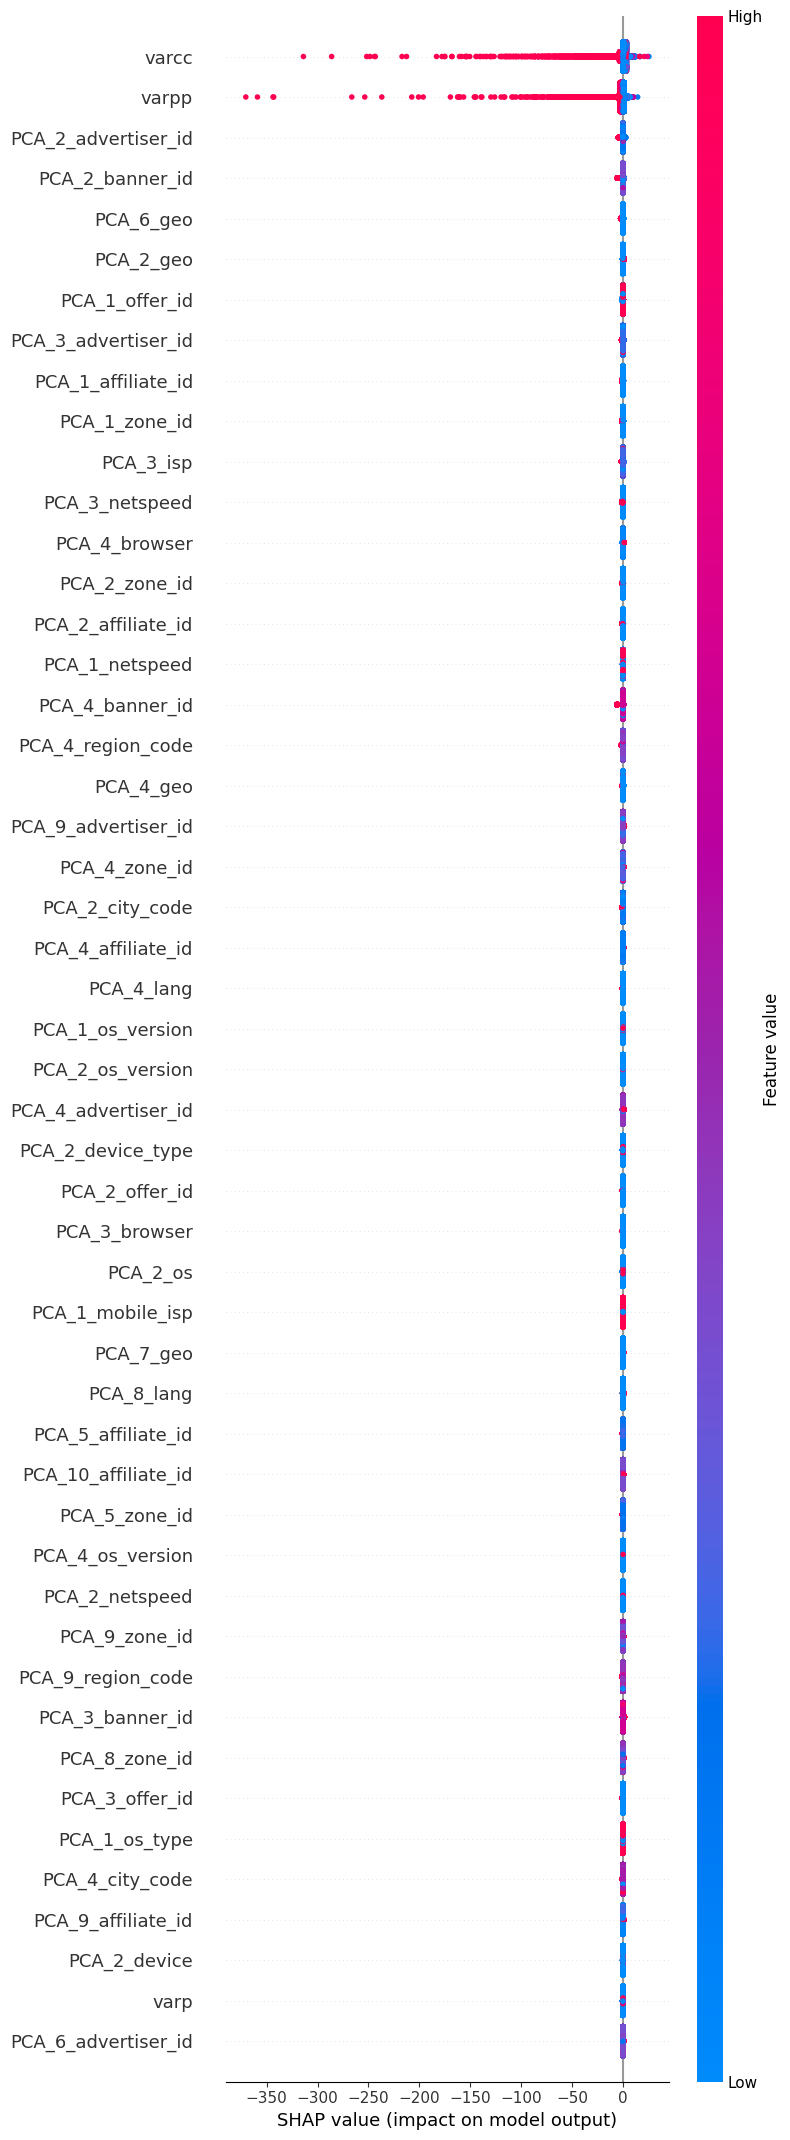

In [ ]:
shap.summary_plot(shap_values1, valid_df_linear.drop(cols_to_drop, axis=1), max_display=50)

In [ ]:
fe1["feature"] = fe1["feature_name"].str.replace("PCA_\d+_", "")
stat2 = fe1.sort_values("abs_coef", ascending=False).iloc[:50,:].groupby("feature")\
  .agg({"feature_name": "count", "abs_coef": ["mean", "max"]})
stat2.columns = ["count", "abs_coef_mean", "abs_coef_max"]
stat2.sort_values("count", ascending=False)

The default value of regex will change from True to False in a future version.


,count,abs_coef_mean,abs_coef_max
feature,,,
advertiser_id,8,0.738706,1.129982
offer_id,6,0.482287,0.675038
banner_id,5,0.531543,0.826279
geo,5,0.407537,0.588700
browser,4,0.644994,1.118069
isp,3,0.380489,0.437261
lang,3,0.642235,1.214493
mobile_isp,3,0.398860,0.464183
zone_id,3,0.522085,0.589329
